In [100]:
import pandas as pd
import numpy as np

In [101]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

## Discretization/Binning

In [102]:
df = pd.read_csv('train.csv',usecols=['Age','Fare','Survived'])

In [103]:
df.shape

(891, 3)

In [104]:
df.dropna(inplace=True) # Age as missing value

In [105]:
df.shape

(714, 3)

In [106]:
df.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [107]:
X = df.iloc[:,1:]
Y = df.iloc[:,0:1]

In [108]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [109]:
X_train.sample(2)

,Age,Fare
119,2.0,31.2750
138,16.0,9.2167


In [110]:
clf = DecisionTreeClassifier()

In [111]:
clf.fit(X_train,Y_train)

pred = clf.predict(X_test)

accuracy_score(Y_test,pred)

0.6223776223776224

In [112]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,Y,cv=10,scoring='accuracy'))

0.63589593114241

In [113]:
kbin_age = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile')
kbin_fare = KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='quantile')

In [114]:
trf = ColumnTransformer([
    ('first',kbin_age,[0]),
    ('second',kbin_age,[1])
]) # no need of passthrough since two columns

In [115]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.fit_transform(X_test)

In [116]:
trf.named_transformers_['first'].n_bins_

array([10])

In [117]:
trf.named_transformers_

{'first': KBinsDiscretizer(encode='ordinal', n_bins=10),
 'second': KBinsDiscretizer(encode='ordinal', n_bins=10)}

In [118]:
trf.named_transformers_['first'].bin_edges_

array([array([ 1. , 11. , 17. , 20.6, 24. , 28. , 30.1, 34.4, 38.6, 47.8, 62. ])],
      dtype=object)

In [119]:
trf.named_transformers_['second'].bin_edges_

array([array([  0.     ,   7.74336,   7.925  ,   8.6625 ,  10.5    ,  14.4542 ,
               22.62   ,  28.39   ,  38.1    ,  57.78336, 512.3292 ])          ],
      dtype=object)

In [120]:
output = pd.DataFrame(
    {
        'age':X_train['Age'],
        'age_trf':X_train_trf[:,0],
        'fare':X_train['Fare'],
        'fare_trf':X_train_trf[:,1]
    }
)

In [121]:
output['age_labels'] = pd.cut(x=X_train['Age'],bins=trf.named_transformers_['first'].bin_edges_[0].tolist())


output['fare_labels'] = pd.cut(x=X_train['Fare'],bins=trf.named_transformers_['second'].bin_edges_[0].tolist())

In [122]:
output.sample(5)

,age,age_trf,fare,fare_trf,age_labels,fare_labels
269,35.0,6.0,135.6333,9.0,"(34.4, 38.6]","(57.783, 512.329]"
242,29.0,5.0,10.5000,3.0,"(28.0, 30.1]","(8.662, 10.5]"
758,34.0,6.0,8.0500,2.0,"(30.1, 34.4]","(7.925, 8.662]"
361,29.0,5.0,27.7208,6.0,"(28.0, 30.1]","(22.62, 28.39]"
586,47.0,8.0,15.0000,4.0,"(38.6, 47.8]","(14.454, 22.62]"


In [123]:
clf = DecisionTreeClassifier()
clf.fit(X_train_trf,Y_train)

pred = clf.predict(X_test_trf)

In [124]:
accuracy_score(pred,Y_test)

0.6853146853146853

In [125]:
def discretizer(bins,encoding,stratergies):
    kbin_age = KBinsDiscretizer(n_bins=bins,encode=encoding,strategy=stratergies)
    kbin_fare = KBinsDiscretizer(n_bins=bins,encode=encoding,strategy=stratergies)

    trf = ColumnTransformer(
        [('first',kbin_age,[0]),
         ('second',kbin_fare,[1])
         ]
    )

    X_trf = trf.fit_transform(X)

    print("Cross Validation Score",np.mean(cross_val_score(DecisionTreeClassifier(),
                                                           X,Y,cv=10,scoring='accuracy')))
    for col in X.columns:
        plt.figure(figsize=(12,4))
        plt.subplot(121)
        plt.hist(X[col],color='red')
        plt.title(f'{col} before Binning/Discretization using {stratergies}')
        plt.legend([col])

        plt.subplot(122)
        plt.hist(X_trf[:,1],color='green')
        plt.title(f'{col} After Binning/Discretization using {stratergies}')
        plt.legend([col])

        plt.show()
        


Cross Validation Score 0.6317488262910798


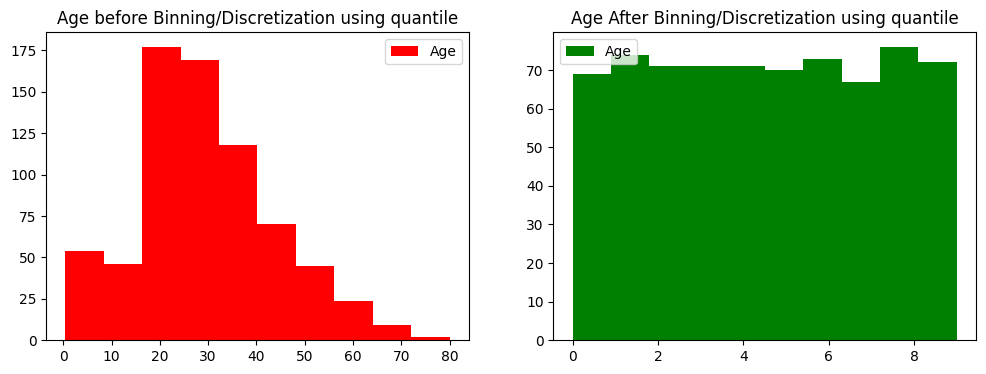

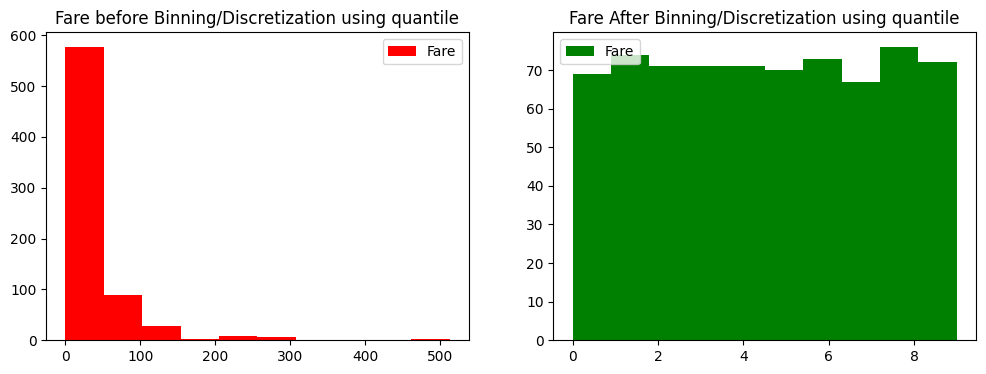

In [126]:
discretizer(10,'ordinal','quantile')# mostly used

Cross Validation Score 0.6359350547730829


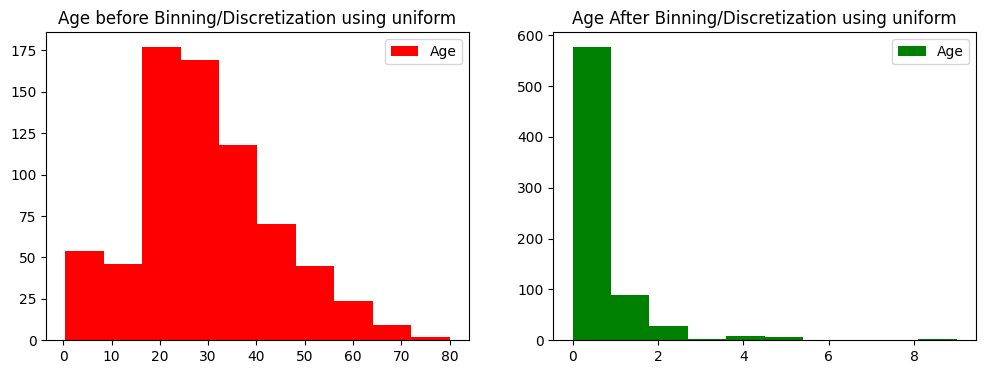

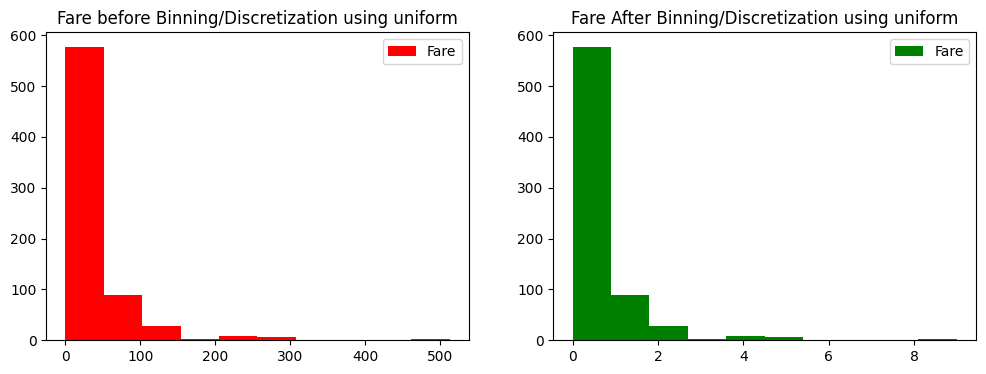

In [127]:
discretizer(10,'ordinal','uniform')

Cross Validation Score 0.635935054773083


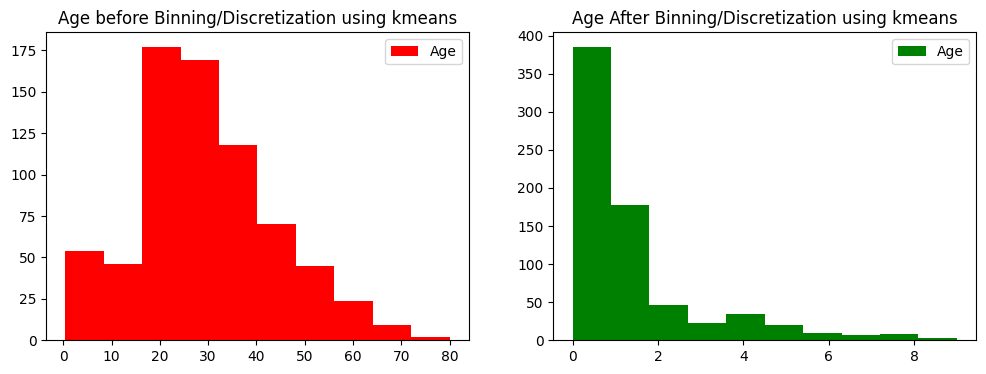

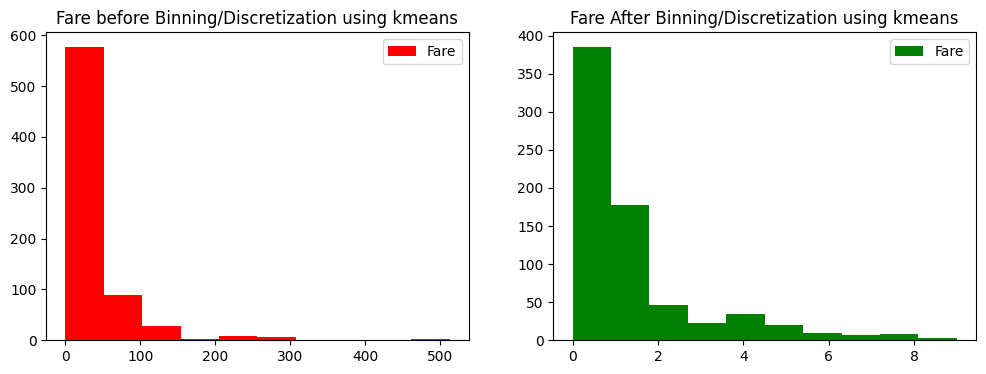

In [128]:
discretizer(10,'ordinal','kmeans')

## Binarization

In [129]:
df = pd.read_csv('train.csv',usecols=['Age','Fare','SibSp','Parch','Survived'])

In [130]:
df

,Survived,Age,SibSp,Parch,Fare
0,0,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,1,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,0,35.0,0,0,8.0500
...,...,...,...,...,...
886,0,27.0,0,0,13.0000
887,1,19.0,0,0,30.0000
888,0,NaN,1,2,23.4500
889,1,26.0,0,0,30.0000


In [131]:
df.dropna(inplace=True)

In [132]:
df.head()

,Survived,Age,SibSp,Parch,Fare
0,0,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,1,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,0,35.0,0,0,8.0500


In [133]:
df['Family']=df['SibSp']+df['Parch']

In [135]:
df.sample(5)

,Survived,Age,SibSp,Parch,Fare,Family
745,0,70.0,1,1,71.0000,2
689,1,15.0,0,1,211.3375,1
71,0,16.0,5,2,46.9000,7
660,1,50.0,2,0,133.6500,2
246,0,25.0,0,0,7.7750,0


In [137]:
df.drop(columns=['Parch','SibSp'],inplace=True)

In [138]:
df.head()

,Survived,Age,Fare,Family
0,0,22.0,7.2500,1
1,1,38.0,71.2833,1
2,1,26.0,7.9250,0
3,1,35.0,53.1000,1
4,0,35.0,8.0500,0


In [140]:
X = df.drop(columns=['Survived'])
Y = df['Survived']

In [141]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [142]:
X_train.head()

,Age,Fare,Family
328,31.0,20.5250,2
73,26.0,14.4542,1
253,30.0,16.1000,1
719,33.0,7.7750,0
666,25.0,13.0000,0


In [143]:
clf = DecisionTreeClassifier()

clf.fit(X_train,Y_train)

pred = clf.predict(X_test)

accuracy_score(Y_test,pred)

0.6223776223776224

In [144]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,Y,scoring='accuracy',cv=10))

0.6428794992175273

In [145]:
from sklearn.preprocessing import Binarizer

In [151]:
trf = ColumnTransformer([
    ('bin',Binarizer(copy=False),['Family']) # Threshold by deafault 0
],remainder="passthrough")
# Here we are trying to find passenger when travelling alone, if Family = 0 alone, else with family member.

In [153]:
X_train_trf = trf.fit_transform(X_train)
X_test_trf = trf.transform(X_test)

In [154]:
pd.DataFrame(X_train_trf,columns=['Family','Age','Fare'])

,Family,Age,Fare
0,1.0,31.0,20.5250
1,1.0,26.0,14.4542
2,1.0,30.0,16.1000
3,0.0,33.0,7.7750
4,0.0,25.0,13.0000
...,...,...,...
566,1.0,46.0,61.1750
567,0.0,25.0,13.0000
568,0.0,41.0,134.5000
569,1.0,33.0,20.5250


In [155]:
clf = DecisionTreeClassifier()

clf.fit(X_train_trf,Y_train)

pred = clf.predict(X_test_trf)

accuracy_score(Y_test,pred)

0.6223776223776224

In [156]:
X_trf = trf.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(),X_trf,Y,scoring='accuracy',cv=10))

0.6219874804381847